![](https://user-images.githubusercontent.com/50156227/163466995-d2a97ffe-ca96-4617-8f42-5772029058c1.gif)

In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageDraw
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Add, Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

In [2]:
IMG_HEIGHT = 416
IMG_WIDTH = 416
X_FACTOR = IMG_WIDTH / 600 # Scale of resizing images
Y_FACTOR = IMG_HEIGHT / 600 # Scale of resizing images
BATCH_SIZE = 128
EPOCHS = 25
learning_rate = 0.003
dataset_path = '../input/ball-localization/ball/'

In [3]:
# Function to read images names and store them in a DataFrame
def grabPaths(filepath):
    labels = [str(filepath[i]).split("/")[-1] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='path').astype(str)
    
    # Concatenate filepaths and labels

    # Shuffle the DataFrame and reset index
    df = pd.DataFrame(filepath)
    
    return df

# Function to scale boxes coordinates (bacuase images are resized)
def resize_boxes(boxes):
    boxes = np.array(boxes).astype(np.float32)
    boxes = boxes * X_FACTOR
    return boxes


# Function to draw bounding box given an image & coordinates
def plot_bbox(image, yt_box, yp_box=None, norm=False):
    # If image is normalized (/255.) reconstruct (inverse) the operation
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    # Convert image to array if not converted
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, w = yt_box
    h = w
    x2, y2 = x1+w, y1+h
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    # If y_pred box is given, draw it
    if yp_box is not None:
        x1, y1, w = yp_box
        h = w
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img


# Function to build convolutionl block
def convblock(previous_layer, n_filters, filter_windows=(3,3,3), padding='same', pool=None):
    # [DepthwiseConv -> BatchNorm -> LeakyReLU] x3 + Residual connection -> Pooling (optional)

    x = SeparableConv2D(n_filters[0], filter_windows[0], padding=padding)(previous_layer)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[1], filter_windows[1], padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[2], filter_windows[2], padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    
    if pool == 'max':
        x = MaxPooling2D(pool_size=(2,2))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=(2,2))(x)
    
    return x

# Function to show samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            batch_index = np.random.randint(0, BATCH_SIZE/2)
            output_classes = np.array(datagen[batch_index][1]['class_out'])
            classes_true = np.where(output_classes == 1)[0]
            sample_index = classes_true[np.random.randint(0, classes_true.shape[0])]
            image = datagen[batch_index][0][sample_index]
            box = datagen[batch_index][1]['box_out'][sample_index]
            plotted_box = plot_bbox(image, box, norm=True)
            ax[i,j].imshow(plotted_box)
            ax[i,j].set_axis_off()
    plt.show()
    


# Function to make a prediction during training
def visualize_prediction(model, data):    
    # Select a sample where an object exists
    output_classes = np.array(custom_test_gen[0][1]['class_out'])
    sample_index = np.where(output_classes == 1)[0]
    sample_index = sample_index[0] if sample_index[0] else 0 
    
    # Get image
    image = np.array([data[0][0][sample_index]])
    
    # Set y_true & y_pred for class & bounding box
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()


# Function to reduce learning rate during training        
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * tf.math.exp(-0.15)
    return lr

# Function to calculate MSE Loss function
# for samples where object exists
def custom_mse(y_true, y_pred):
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    return result

In [4]:
# Read CSV
dataset = pd.read_csv('../input/ball-localization/dataset.csv')
dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']


# List directories of files
train_image_dir_hand = Path('../input/ball-localization/ball')
train_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.png'))

# Create dataframe of {paths, labels}
train_df_hand = grabPaths(train_filepaths_hand)

dataset['path'] = "../input/ball-localization/ball/" + dataset['path']


# Resize boxes, keep zeros if no object exists
dataset.iloc[:,2:] = resize_boxes(dataset.iloc[:,2:])

[Text(0.5, 0, 'Object exists in image'), Text(0, 0.5, 'No. of Image')]

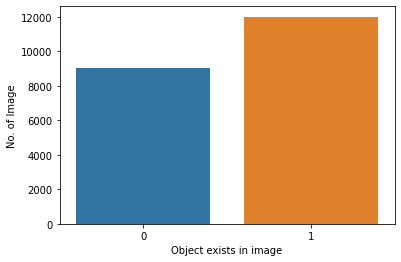

In [5]:
ax = sns.countplot(x='ball_exists', data=dataset)
ax.set(xlabel='Object exists in image', ylabel='No. of Image')

In [6]:
# balance dataset (undersampling)
balls = dataset[dataset['ball_exists'] == 1]
noballs = dataset[dataset['ball_exists'] == 0]
balls = balls.sample(frac=0.75).reset_index(drop=True)

# merge balanced classes & shuffle
train_df = pd.concat((balls, noballs)).sample(frac=1.).reset_index(drop=True)

train_df, test_df = train_test_split(train_df, test_size=0.2)

print(f"No. Training Samples: {train_df.shape[0]}\nNo. Validation Samples: {test_df.shape[0]}")

No. Training Samples: 14400
No. Validation Samples: 3600


In [7]:
# Create custom Generator for multiple output models
class MultiOutputGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen, output_gen):
        self.inpgen = input_gen
        self.outgen = output_gen
#         assert len(input_gen) == len(output_gen)

    def __len__(self):
        return len(self.inpgen)

    def __getitem__(self, i):
        images = self.inpgen[i]
        start = i * images.shape[0]
        end = (i+1) * images.shape[0]
        classes_num = self.outgen.iloc[start:end,0].values
        x = self.outgen.iloc[start:end,1]
        y = self.outgen.iloc[start:end,2]
        w = self.outgen.iloc[start:end,3]
#         h = self.outgen.iloc[start:end,4]
        return images, {'class_out':classes_num, 'box_out':np.array([x, y, w]).T}

    def on_epoch_end(self):
        self.inpgen.on_epoch_end()
    
# Class to visualize predictions during training
class ConvergenceVisualization(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global custom_test_gen
        visualize_prediction(self.model, custom_test_gen)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    rescale = 1./255.,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Create multi-output generator
custom_train_gen = MultiOutputGen(train_images, train_df.iloc[:,1:])
custom_test_gen = MultiOutputGen(test_images, test_df.iloc[:,1:])

Found 14400 validated image filenames.
Found 3600 validated image filenames.


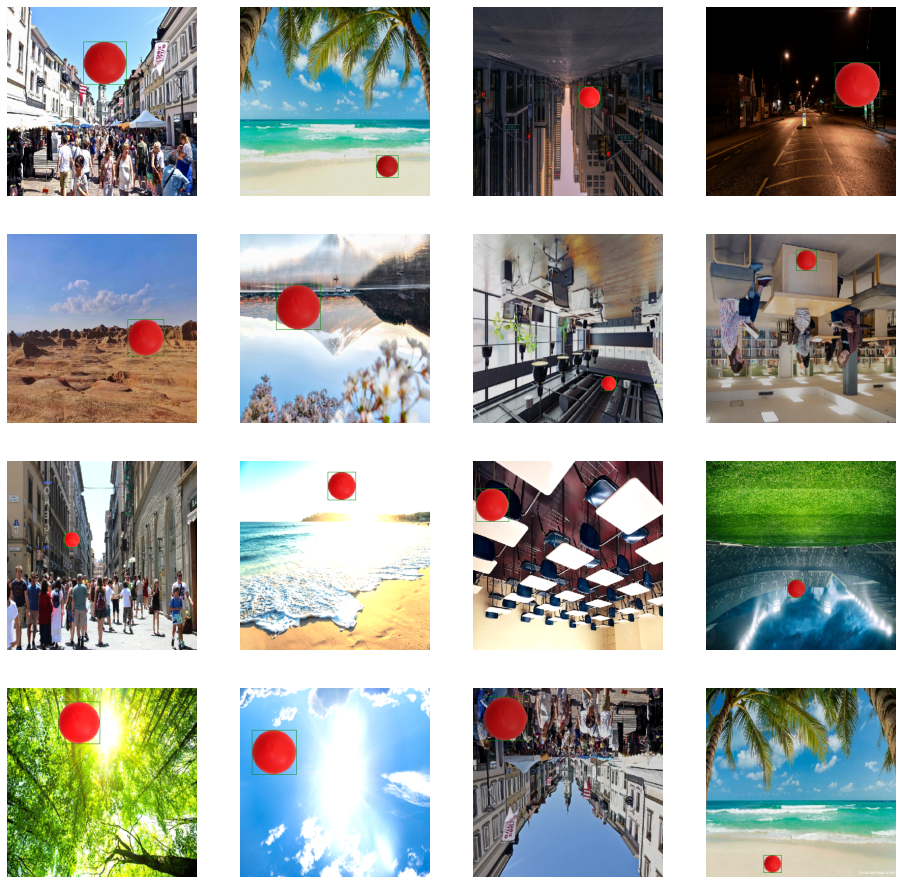

In [9]:
visualize_samples(custom_train_gen)

In [10]:
# BEST MODEL

inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3), name='image')

X = SeparableConv2D(64, (7,7), strides=2, padding='valid')(inp)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = SeparableConv2D(192, (3,3), strides=1, padding='same')(X)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = convblock(X, [16, 16, 16], pool='max')
X = convblock(X, [32, 32, 32], pool='max')
X = convblock(X, [64, 64, 64], pool='max')
X = convblock(X, [128, 128, 128], pool='max')
X = convblock(X, [256, 256, 256])

X = Flatten()(X)
boxX = Dense(512)(X)
boxX = LeakyReLU()(boxX)

classX = Dense(128)(X)
classX = LeakyReLU()(classX)

box_out = Dense(3, name='box_out')(boxX)
class_out = Dense(1, name='class_out', activation='sigmoid')(classX)


model = Model(inp, [class_out, box_out])
model.summary()

2022-04-15 16:51:49.362280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 16:51:49.518987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 16:51:49.519792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 16:51:49.520928: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 205, 205, 64) 403         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 102, 102, 64) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 102, 102, 192 13056       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss={
        "box_out":custom_mse,
        'class_out':'binary_crossentropy'
    },
    metrics={
        'class_out':'accuracy'
    },
    optimizer=adam
)

2022-04-15 16:51:54.687471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-04-15 16:52:02.354635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


113/113 [==============================] - 567s 5s/step - loss: 1885.8379 - class_out_loss: 0.2744 - box_out_loss: 1885.5635 - class_out_accuracy: 0.9046 - val_loss: 24126.0586 - val_class_out_loss: 0.7590 - val_box_out_loss: 24125.2969 - val_class_out_accuracy: 0.4914
Class: y_true= [1]  | y_pred= 1


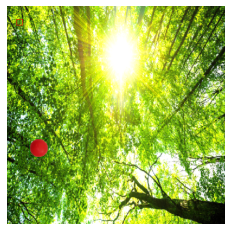

Epoch 2/25
113/113 [==============================] - 420s 4s/step - loss: 273.5403 - class_out_loss: 0.0623 - box_out_loss: 273.4780 - class_out_accuracy: 0.9889 - val_loss: 15874.2988 - val_class_out_loss: 0.7847 - val_box_out_loss: 15873.5146 - val_class_out_accuracy: 0.5086
Class: y_true= [1]  | y_pred= 0


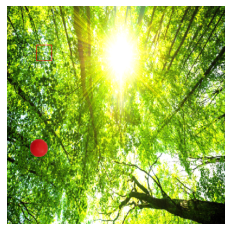

Epoch 3/25
113/113 [==============================] - 414s 4s/step - loss: 191.2270 - class_out_loss: 0.0377 - box_out_loss: 191.1893 - class_out_accuracy: 0.9928 - val_loss: 8426.6123 - val_class_out_loss: 2.7285 - val_box_out_loss: 8423.8838 - val_class_out_accuracy: 0.5086
Class: y_true= [1]  | y_pred= 0


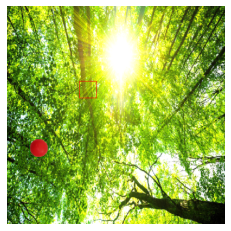

Epoch 4/25
113/113 [==============================] - 436s 4s/step - loss: 161.5901 - class_out_loss: 0.0433 - box_out_loss: 161.5469 - class_out_accuracy: 0.9910 - val_loss: 4019.5679 - val_class_out_loss: 1.7646 - val_box_out_loss: 4017.8027 - val_class_out_accuracy: 0.5700
Class: y_true= [1]  | y_pred= 0


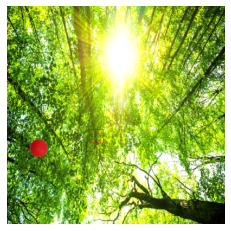

Epoch 5/25
113/113 [==============================] - 402s 4s/step - loss: 172.0029 - class_out_loss: 0.0331 - box_out_loss: 171.9697 - class_out_accuracy: 0.9959 - val_loss: 169.7543 - val_class_out_loss: 0.0703 - val_box_out_loss: 169.6840 - val_class_out_accuracy: 0.9842
Class: y_true= [1]  | y_pred= 1


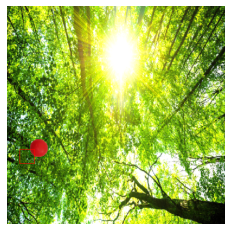

Epoch 6/25
113/113 [==============================] - 438s 4s/step - loss: 155.6803 - class_out_loss: 0.0355 - box_out_loss: 155.6448 - class_out_accuracy: 0.9944 - val_loss: 497.8783 - val_class_out_loss: 0.0255 - val_box_out_loss: 497.8528 - val_class_out_accuracy: 0.9969
Class: y_true= [1]  | y_pred= 1


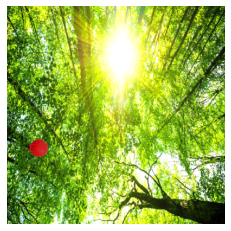

Epoch 7/25
113/113 [==============================] - 443s 4s/step - loss: 143.6804 - class_out_loss: 0.0393 - box_out_loss: 143.6411 - class_out_accuracy: 0.9945 - val_loss: 147.6032 - val_class_out_loss: 0.0301 - val_box_out_loss: 147.5731 - val_class_out_accuracy: 0.9947
Class: y_true= [1]  | y_pred= 1


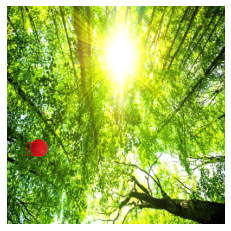

Epoch 8/25
113/113 [==============================] - 419s 4s/step - loss: 114.8539 - class_out_loss: 0.0242 - box_out_loss: 114.8298 - class_out_accuracy: 0.9976 - val_loss: 567.3387 - val_class_out_loss: 0.1408 - val_box_out_loss: 567.1980 - val_class_out_accuracy: 0.9531
Class: y_true= [1]  | y_pred= 1


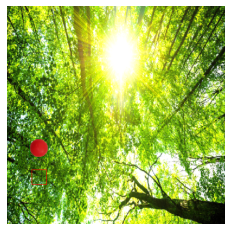

Epoch 9/25
113/113 [==============================] - 443s 4s/step - loss: 135.0154 - class_out_loss: 0.0532 - box_out_loss: 134.9622 - class_out_accuracy: 0.9799 - val_loss: 218.4746 - val_class_out_loss: 0.0347 - val_box_out_loss: 218.4399 - val_class_out_accuracy: 0.9958
Class: y_true= [1]  | y_pred= 1


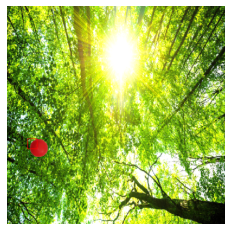

Epoch 10/25
113/113 [==============================] - 456s 4s/step - loss: 173.6061 - class_out_loss: 0.0490 - box_out_loss: 173.5571 - class_out_accuracy: 0.9927 - val_loss: 5548.1343 - val_class_out_loss: 0.3563 - val_box_out_loss: 5547.7788 - val_class_out_accuracy: 0.9047
Class: y_true= [1]  | y_pred= 1


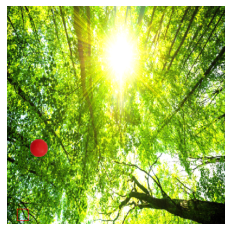

Epoch 11/25
113/113 [==============================] - 447s 4s/step - loss: 121.1131 - class_out_loss: 0.0305 - box_out_loss: 121.0826 - class_out_accuracy: 0.9964 - val_loss: 397.4463 - val_class_out_loss: 0.0382 - val_box_out_loss: 397.4080 - val_class_out_accuracy: 0.9944
Class: y_true= [1]  | y_pred= 1


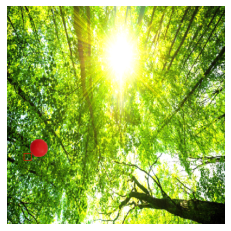

Epoch 12/25
113/113 [==============================] - 428s 4s/step - loss: 158.4198 - class_out_loss: 0.0386 - box_out_loss: 158.3813 - class_out_accuracy: 0.9926 - val_loss: 447.1521 - val_class_out_loss: 0.0395 - val_box_out_loss: 447.1126 - val_class_out_accuracy: 0.9908
Class: y_true= [1]  | y_pred= 1


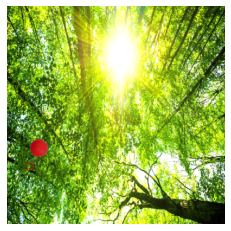

Epoch 13/25
113/113 [==============================] - 421s 4s/step - loss: 122.4281 - class_out_loss: 0.0289 - box_out_loss: 122.3992 - class_out_accuracy: 0.9949 - val_loss: 115.9692 - val_class_out_loss: 0.0281 - val_box_out_loss: 115.9411 - val_class_out_accuracy: 0.9942
Class: y_true= [1]  | y_pred= 1


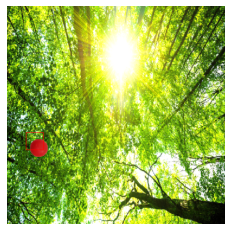

Epoch 14/25
113/113 [==============================] - 428s 4s/step - loss: 106.1324 - class_out_loss: 0.0224 - box_out_loss: 106.1101 - class_out_accuracy: 0.9971 - val_loss: 97.7945 - val_class_out_loss: 0.0189 - val_box_out_loss: 97.7756 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


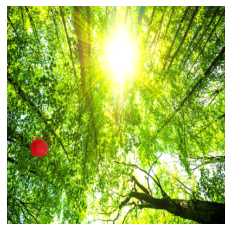

Epoch 15/25
113/113 [==============================] - 443s 4s/step - loss: 64.0830 - class_out_loss: 0.0175 - box_out_loss: 64.0655 - class_out_accuracy: 0.9976 - val_loss: 198.6998 - val_class_out_loss: 0.0202 - val_box_out_loss: 198.6796 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


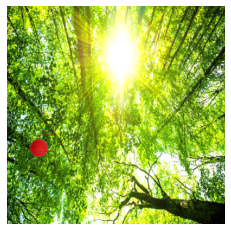

Epoch 16/25
113/113 [==============================] - 437s 4s/step - loss: 80.6830 - class_out_loss: 0.0192 - box_out_loss: 80.6638 - class_out_accuracy: 0.9971 - val_loss: 96.3720 - val_class_out_loss: 0.0183 - val_box_out_loss: 96.3537 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


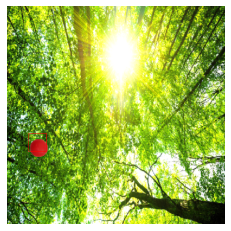

Epoch 17/25
113/113 [==============================] - 446s 4s/step - loss: 67.4839 - class_out_loss: 0.0236 - box_out_loss: 67.4604 - class_out_accuracy: 0.9967 - val_loss: 82.0596 - val_class_out_loss: 0.0208 - val_box_out_loss: 82.0388 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


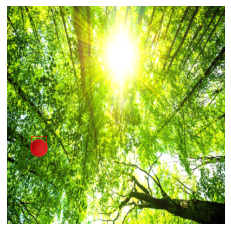

Epoch 18/25
113/113 [==============================] - 450s 4s/step - loss: 51.5710 - class_out_loss: 0.0170 - box_out_loss: 51.5540 - class_out_accuracy: 0.9976 - val_loss: 118.4252 - val_class_out_loss: 0.0201 - val_box_out_loss: 118.4051 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


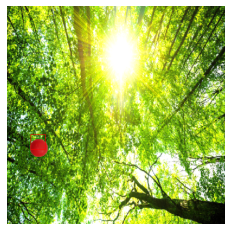

Epoch 19/25
113/113 [==============================] - 446s 4s/step - loss: 52.5642 - class_out_loss: 0.0179 - box_out_loss: 52.5463 - class_out_accuracy: 0.9975 - val_loss: 74.9305 - val_class_out_loss: 0.0179 - val_box_out_loss: 74.9126 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


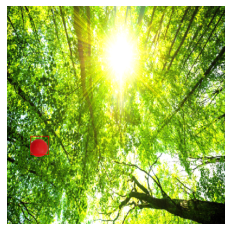

Epoch 20/25
113/113 [==============================] - 452s 4s/step - loss: 49.0580 - class_out_loss: 0.0187 - box_out_loss: 49.0393 - class_out_accuracy: 0.9976 - val_loss: 72.2313 - val_class_out_loss: 0.0180 - val_box_out_loss: 72.2134 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


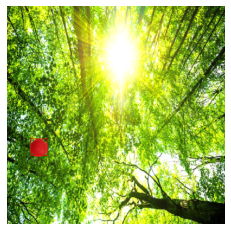

Epoch 21/25
113/113 [==============================] - 427s 4s/step - loss: 41.8780 - class_out_loss: 0.0162 - box_out_loss: 41.8618 - class_out_accuracy: 0.9977 - val_loss: 91.3393 - val_class_out_loss: 0.0237 - val_box_out_loss: 91.3156 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


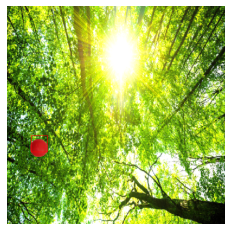

Epoch 22/25
113/113 [==============================] - 433s 4s/step - loss: 39.3406 - class_out_loss: 0.0161 - box_out_loss: 39.3245 - class_out_accuracy: 0.9978 - val_loss: 94.3264 - val_class_out_loss: 0.0208 - val_box_out_loss: 94.3056 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


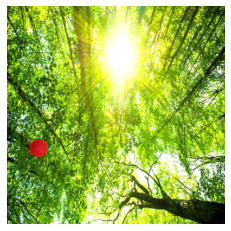

Epoch 23/25
113/113 [==============================] - 443s 4s/step - loss: 39.7097 - class_out_loss: 0.0170 - box_out_loss: 39.6926 - class_out_accuracy: 0.9977 - val_loss: 89.9212 - val_class_out_loss: 0.0206 - val_box_out_loss: 89.9005 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


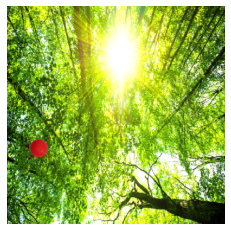

Epoch 24/25
113/113 [==============================] - 454s 4s/step - loss: 39.2636 - class_out_loss: 0.0167 - box_out_loss: 39.2469 - class_out_accuracy: 0.9977 - val_loss: 69.4100 - val_class_out_loss: 0.0178 - val_box_out_loss: 69.3923 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


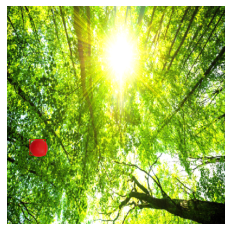

Epoch 25/25
113/113 [==============================] - 435s 4s/step - loss: 35.5894 - class_out_loss: 0.0157 - box_out_loss: 35.5738 - class_out_accuracy: 0.9978 - val_loss: 73.1138 - val_class_out_loss: 0.0188 - val_box_out_loss: 73.0951 - val_class_out_accuracy: 0.9975
Class: y_true= [1]  | y_pred= 1


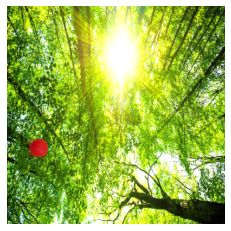

In [12]:
history = model.fit(
    custom_train_gen,
    epochs=EPOCHS,
    validation_data=custom_test_gen,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
        ConvergenceVisualization()
    ]
)

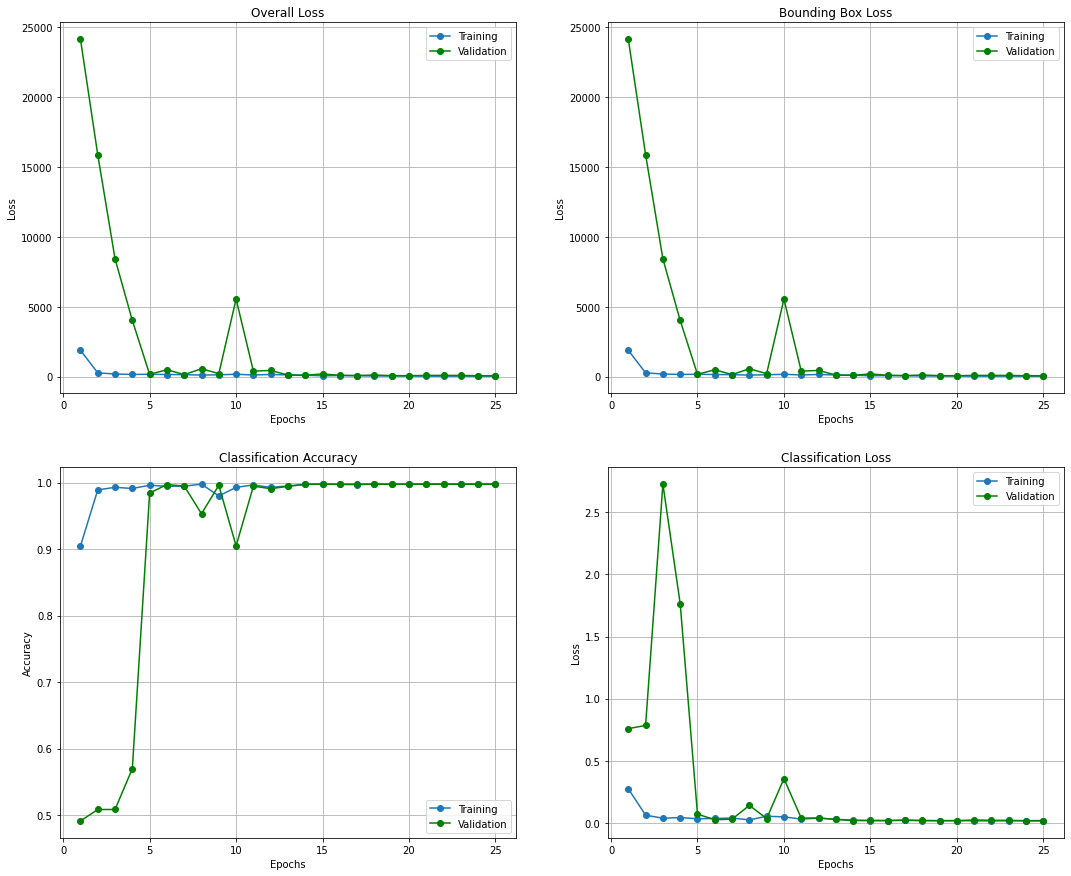

In [13]:
# Accuracy & Loss Visualization

#  Overall Loss
train_overall_loss = history.history['loss']
val_overall_loss = history.history['val_loss']

# Classification Accuracy
train_classification_acc = history.history['class_out_accuracy']
val_classification_acc = history.history['val_class_out_accuracy']

# Classification Loss
train_classification_loss = history.history['class_out_loss']
val_classification_loss = history.history['val_class_out_loss']

# Bounding Box Loss
train_bbox_loss = history.history['box_out_loss']
val_bbox_loss = history.history['val_box_out_loss']

epochs = range(1, len(history.history['loss'])+1)

f, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
    
ax[0,0].plot(epochs, train_overall_loss,  marker='o', label='Training')
ax[0,0].plot(epochs, val_overall_loss, marker='o', color = 'green', label='Validation')
ax[0,0].set_title('Overall Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend(loc='best')
ax[0,0].grid(True)

ax[0,1].plot(epochs, train_bbox_loss, marker='o', label='Training')
ax[0,1].plot(epochs, val_bbox_loss, marker='o', color = 'green', label='Validation')
ax[0,1].set_title('Bounding Box Loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend(loc='best')
ax[0,1].grid(True)



ax[1,0].plot(epochs, train_classification_acc,  marker='o', label='Training')
ax[1,0].plot(epochs, val_classification_acc, marker='o', color = 'green', label='Validation')
ax[1,0].set_title('Classification Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].legend(loc='best')
ax[1,0].grid(True)

ax[1,1].plot(epochs, train_classification_loss, marker='o', label='Training')
ax[1,1].plot(epochs, val_classification_loss, marker='o', color = 'green', label='Validation')
ax[1,1].set_title('Classification Loss')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend(loc='best')
ax[1,1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()

In [14]:
model.save("final ball detection.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
